# 1. INTRODUCTION

**PROBLEM STATEMENT: PREDICT SOFTWARE DEFECTS**

<font size="3">Welcome to the Episode 23 of the Playground Series</font>

**Data Description**

1. loc: numeric - McCabe's line count of code
2. v(g): numeric - McCabe "cyclomatic complexity"
3. ev(g): numeric - McCabe "essential complexity"
4. iv(g): numeric - McCabe "design complexity"
5. n: numeric - Halstead total operators + operands
6. v: numeric - Halstead "volume"
7. l: numeric - Halstead "program length"
8. d: numeric - Halstead "difficulty"
9. i: numeric - Halstead "intelligence"
10. e: numeric - Halstead "effort"
11. b: numeric - Halstead 
12. t: numeric - Halstead's time estimator
13. lOCode: numeric - Halstead's line count
14. lOComment: numeric - Halstead's count of lines of comments
15. lOBlank: numeric - Halstead's count of blank lines
16. lOCodeAndComment: numeric
17. uniq_Op: numeric - unique operators
18. uniq_Opnd: numeric - unique operands
19. total_Op: numeric - total operators
20. total_Opnd: numeric - total operands
21. branchCount: numeric - percentage of the flow graph
22. defects: {false, true} - module has/has not one or more reported defects

**Objective:** Binary Classification on Defects, predict the probability of defect

**Metric of Evaluation:** ROC-AUC


# 2. IMPORTS

In [1]:
import sklearn
import numpy as np
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks = []
# !pip install sweetviz
# import sweetviz as sv
import concurrent.futures
from copy import deepcopy       
from functools import partial
from itertools import combinations
import random
from random import randint, uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from sklearn.impute import SimpleImputer
import xgboost as xg
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_squared_log_error, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.cluster import KMeans
# !pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
# !pip install gap-stat
from gap_statistic.optimalK import OptimalK
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
# !pip install optuna
import optuna
import xgboost as xgb
# !pip install catboost
# !pip install lightgbm --install-option=--gpu --install-option="--boost-root=C:/local/boost_1_69_0" --install-option="--boost-librarydir=C:/local/boost_1_69_0/lib64-msvc-14.1"
import lightgbm as lgb
# !pip install category_encoders
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
# !pip install -U imbalanced-learn
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import Pool
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

ModuleNotFoundError: No module named 'missingno'

In [2]:
train = pd.read_csv('../input/playground-series-s3e23/train.csv', index_col='id')
original = pd.read_csv('../input/software-defect-prediction/jm1.csv')

cols=['uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']
def convert(x):
    try: 
        return float(x)
    except ValueError:
        return np.nan
for col in cols:
    original[col]=original[col].apply(convert)
original=original.dropna()

train_processed = pd.read_csv('../input/ps3e23-eda-feature-engineering-ensemble/train_processed.csv')
test_processed = pd.read_csv('../input/ps3e23-eda-feature-engineering-ensemble/test_processed.csv')

train=pd.concat([train,original],axis=0)

In [3]:
X_train = train_processed.drop(columns=['defects'])
y_train = train['defects'].astype(int)

X_test = test_processed.copy()

In [4]:
def get_most_important_features(X_train, y_train, n,model_input):
    xgb_params = {
            'n_jobs': -1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': 42,
        }
    lgb_params = {
            'objective': 'binary',
            'metric': 'logloss',
            'boosting_type': 'gbdt',
            'random_state': 42,
        }
    cb_params = {
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'AUC',
            'loss_function': 'Logloss',
            'random_state': 42,
        }
    
    et_params = {
        'random_state': 42,
        'n_jobs': -1
    }
    if 'xgb' in model_input:
        model = xgb.XGBClassifier(**xgb_params)
    elif 'cat' in model_input:
        model=CatBoostClassifier(**cb_params)
    elif 'lgbm':
        model=lgb.LGBMClassifier(**lgb_params)
    elif 'et':
        model=ExtraTreesClassifier(**et_params)
        
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    feature_importances_list = []
    
    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold, verbose=False)
        
        y_pred = model.predict_proba(X_val_fold)[:,1]
        auc_scores.append(roc_auc_score(y_val_fold, y_pred))
        feature_importances = model.feature_importances_
        feature_importances_list.append(feature_importances)

    avg_auc= np.mean(auc_scores)
    avg_feature_importances = np.mean(feature_importances_list, axis=0)

    feature_importance_list = [(X_train.columns[i], importance) for i, importance in enumerate(avg_feature_importances)]
    sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
    top_n_features = [feature[0] for feature in sorted_features[:n]]

    display_features=top_n_features[:10]
    
    sns.set_palette("Set2")
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(display_features)), [avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features])
    plt.yticks(range(len(display_features)), display_features, fontsize=12)
    plt.xlabel('Average Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=10)
    plt.title(f'Top {10} of {n} Feature Importances with ROC AUC score {avg_auc}', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Add data labels on the bars
    for index, value in enumerate([avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features]):
        plt.text(value + 0.005, index, f'{value:.3f}', fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

    return top_n_features

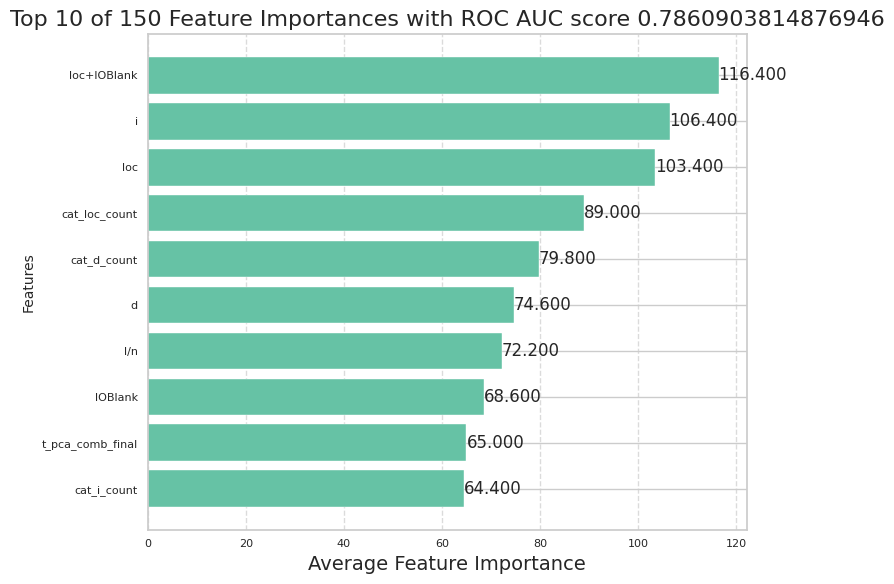

150 features have been selected from three algorithms for the final model


In [5]:
n_imp_features_cat = []
n_imp_features_xgb = []
n_imp_features_lgbm = []
n_imp_features_et = []

# n_imp_features_cat=get_most_important_features(X_train.reset_index(drop=True), y_train,150, 'cat')
# n_imp_features_xgb=get_most_important_features(X_train.reset_index(drop=True), y_train,150, 'xgb')
# n_imp_features_lgbm=get_most_important_features(X_train.reset_index(drop=True), y_train,150, 'lgbm')
n_imp_features_et = get_most_important_features(X_train.reset_index(drop=True), y_train,150, 'et')

n_imp_features=[*set(n_imp_features_xgb+n_imp_features_lgbm+n_imp_features_cat+n_imp_features_et)]
print(f"{len(n_imp_features)} features have been selected from three algorithms for the final model")

In [6]:
X_train=X_train[n_imp_features]
X_test=X_test[n_imp_features]

# 6. XGBoost

In [7]:
from sklearn.pipeline import make_pipeline
N_TRIALS=30
SPLITS=5
SEED=42

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600, 100),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1]),
        'random_state': trial.suggest_categorical('random_state', [SEED]),
        'max_depth': trial.suggest_int('max_depth', 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
        'criterion': trial.suggest_categorical("criterion", ["gini"]),
        'max_features': trial.suggest_categorical('max_features', [1.0]),
    }

    pipeline = make_pipeline(ExtraTreesClassifier(**params))
    scores = cross_val_score(pipeline, X_train, y_train, cv=SPLITS, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

[I 2023-10-20 19:28:30,391] A new study created in memory with name: no-name-552550c1-0588-4386-ac8a-3cd0e46752d3


  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
study.best_params, study.best_value

In [ ]:
pipeline = make_pipeline(ExtraTreesClassifier(**study.best_params))
pipeline.fit(X_train, y_train)

In [ ]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e23/sample_submission.csv', )
submission['defects'] = pipeline.predict_proba(X_test)[:, 1]
submission.to_csv('submission.csv', index=False)